In [ ]:
!git clone https://github.com/keras-team/keras-tuner

In [ ]:
cd keras-tuner

In [ ]:
!pip install .

In [5]:
# Train a DNN model for prediction

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kerastuner as kt



# upload the data base at the certain path
data = pd.read_csv('/content/trainset.csv')  
x_train = data.loc[0:506, ['A','B','C','D','E','F']]
x_train=np.array(x_train)
y_train = data.loc[0:506, ['target']]
y_train=np.array(y_train)

#Define model
def model_builder(hp):
  model = keras.Sequential()
#Set the input layer
  model.add(keras.layers.Flatten(input_shape=(6,1)))
#In here, we tuner the number of layers using for loop
  for i in range(hp.Int('num_layers', 2 , 5)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                      min_value=6,
                      max_value=50,
                      step=1),
                activation= 'relu'))
  model.add(keras.layers.Dense(1, activation='linear'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
         optimizer=tf.keras.optimizers.RMSprop(lr=hp_learning_rate, rho=0.9, epsilon=1e-06),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
  return model
       

tuner = kt.RandomSearch(model_builder,
                     objective='val_mean_absolute_error',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='kerastuner')
# represent the search space
tuner.search_space_summary()

# search the best hyperparameters
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train,y_train,epochs=50,validation_split=0.2,callbacks=[stop_early])

# recall the overall hyperparameters
tuner.results_summary()

# train model with the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

#manifest the model structure
model.summary()

#extract the best hyperparameters 
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

Trial 5 Complete [00h 00m 05s]
val_mean_absolute_error: 3.658336877822876

Best val_mean_absolute_error So Far: 3.4078466097513833
Total elapsed time: 00h 00m 31s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/kerastuner
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 20
units_1: 12
learning_rate: 0.01
Score: 3.4078466097513833
Trial summary
Hyperparameters:
num_layers: 4
units_0: 31
units_1: 6
learning_rate: 0.01
units_2: 36
units_3: 6
Score: 3.658336877822876
Trial summary
Hyperparameters:
num_layers: 3
units_0: 21
units_1: 32
learning_rate: 0.001
units_2: 6
Score: 5.176993529001872
Trial summary
Hyperparameters:
num_layers: 3
units_0: 12
units_1: 12
learning_rate: 0.0001
units_2: 36
Score: 5.287246863047282
Trial summary
Hyperparameters:
num_layers: 3
units_0: 45
units_1: 39
learning_rate: 0.0001
units_2: 7
Score: 5.806533972422282
Model: "sequential"
____________________

{'learning_rate': 0.01, 'num_layers': 2, 'units_0': 20, 'units_1': 12}

In [ ]:
!pip3 install pygad

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:632: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


Generation = 1
Fitness    = [-2.0835314]
Change     = [-2.0835314]
Generation = 2
Fitness    = [-2.0835314]
Change     = [-0.149714]
Generation = 3
Fitness    = [-2.2332454]
Change     = [-6.93798]
Generation = 4
Fitness    = [-9.171226]
Change     = [-20.346466]
Generation = 5
Fitness    = [-29.517693]
Change     = [26.865784]
Generation = 6
Fitness    = [-2.6519094]
Change     = [-10.83864]
Generation = 7
Fitness    = [-13.49055]
Change     = [10.742122]
Generation = 8
Fitness    = [-2.748428]
Change     = [-17.147463]
Generation = 9
Fitness    = [-19.895891]
Change     = [13.950018]
Generation = 10
Fitness    = [-5.9458733]
Change     = [2.5014298]
Generation = 11
Fitness    = [-3.4444435]
Change     = [-3.771126]
Generation = 12
Fitness    = [-7.2155695]
Change     = [4.81538]
Generation = 13
Fitness    = [-2.4001896]
Change     = [60.18867]
Generation = 14
Fitness    = [57.788483]
Change     = [-66.38577]
Generation = 15
Fitness    = [-8.597291]
Change     = [12.3150015]
Generatio

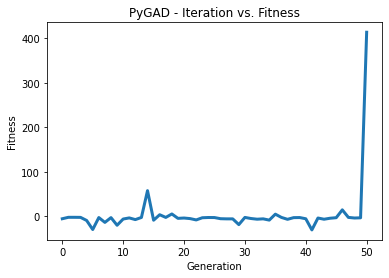

Parameters of the best solution : [0.29 1.21 0.7  0.95 1.6  0.42]
Fitness value of the best solution = [-47.54311]


In [15]:
# Optimization for input features

import numpy as np
import pygad

#define fitness function
def fitness_func(solution, solution_idx):
    # solution[i] represeent the value of the (i+1)th parameter in solution
    solution=np.empty(shape=(1,6))
    output=model(solution) # model is built in keras.tuner
    fitness =(1/(output)).numpy()[0]
    return fitness

# Number of generations.
num_generations = 50 
# Number of solutions to be selected as parents in the mating pool.
num_parents_mating = 5 
# Number of solutions in the population.
sol_per_pop = 10 
  
# Type of parent selection.
parent_selection_type = "sss"
# Type of the crossover operator.
crossover_type = "single_point" 
# Type of the mutation operator.
mutation_type = "random"

last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_instance = pygad.GA(
     #Number of generations(iterations).
     num_generations=num_generations,
     num_parents_mating=num_parents_mating,
     fitness_func=fitness_func,
     sol_per_pop=sol_per_pop,
     #the Number of parameters(the number of genes)
     num_genes=6,
     gene_space=[np.arange(0,2 ,0.01).tolist(),np.arange(0,2,0.01).tolist(),np.arange(0,2,0.01).tolist(),np.arange(0,2,0.01).tolist(),
                 np.arange(0,2,0.01).tolist(),np.arange(0,2,0.01).tolist()],
     
     parent_selection_type=parent_selection_type,
     keep_parents=1,
     crossover_type=crossover_type,
     mutation_percent_genes=50,
     mutation_type=mutation_type,
     callback_generation=callback_generation)

# Running the GA to optimize the parameters of the function.
ga_instance.run()


# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))